In [2]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.svm import SVC


In [3]:
sns.set_style("whitegrid")
pd.set_option('display.max_columns', None)

# ---------- 1) Chargement ----------
df = pd.read_csv("vih.csv")
print("Aperçu :")
display(df.head())
print("\nColonnes :", df.columns.tolist())


Aperçu :


,Country,Reported number of people receiving ART,Estimated number of people living with HIV,Estimated ART coverage among people living with HIV (%),Estimated number of people living with HIV_median,Estimated number of people living with HIV_min,Estimated number of people living with HIV_max,Estimated ART coverage among people living with HIV (%)_median,Estimated ART coverage among people living with HIV (%)_min,Estimated ART coverage among people living with HIV (%)_max,WHO Region
0,Afghanistan,920,7200[4100–11000],13[7–20],7200.0,4100.0,11000.0,13.0,7.0,20.0,Eastern Mediterranean
1,Albania,580,Nodata,Nodata,NaN,NaN,NaN,NaN,NaN,NaN,Europe
2,Algeria,12800,16000[15000–17000],81[75–86],16000.0,15000.0,17000.0,81.0,75.0,86.0,Africa
3,Angola,88700,330000[290000–390000],27[23–31],330000.0,290000.0,390000.0,27.0,23.0,31.0,Africa
4,Argentina,85500,140000[130000–150000],61[55–67],140000.0,130000.0,150000.0,61.0,55.0,67.0,Americas



Colonnes : ['Country', 'Reported number of people receiving ART', 'Estimated number of people living with HIV', 'Estimated ART coverage among people living with HIV (%)', 'Estimated number of people living with HIV_median', 'Estimated number of people living with HIV_min', 'Estimated number of people living with HIV_max', 'Estimated ART coverage among people living with HIV (%)_median', 'Estimated ART coverage among people living with HIV (%)_min', 'Estimated ART coverage among people living with HIV (%)_max', 'WHO Region']


In [4]:
df = df.replace(['Nodata', 'Nodata', 'No data', 'NA', ''], np.nan)

# Fonction utilitaire : extraire le premier nombre entier (ou décimal) avant crochets
def extract_number(x):
    if pd.isna(x):
        return np.nan
    # Convert to str
    s = str(x)
    # Look for a leading number (allow commas)
    m = re.search(r'([0-9][0-9,]*)', s)
    if m:
        num = m.group(1).replace(',', '')
        try:
            return float(num)
        except:
            return np.nan
    return np.nan

In [5]:
col_reported_art = 'Reported number of people receiving ART'
col_est_plhiv = 'Estimated number of people living with HIV'
col_cov = 'Estimated ART coverage among people living with HIV (%)'
col_est_plhiv_median = 'Estimated number of people living with HIV_median'
col_cov_median = 'Estimated ART coverage among people living with HIV (%)_median'
col_region = 'WHO Region'


In [6]:
df['ART_reported_num'] = pd.to_numeric(df[col_reported_art].astype(str).str.replace(',',''), errors='coerce')


In [7]:
df['Est_PLHIV_parsed'] = df[col_est_plhiv].apply(extract_number)


In [8]:
df['Coverage_parsed'] = df[col_cov].apply(extract_number)

In [9]:
df['Est_PLHIV_median_num'] = pd.to_numeric(df[col_est_plhiv_median].astype(str).str.replace(',',''), errors='coerce')
df['Coverage_median_num'] = pd.to_numeric(df[col_cov_median].astype(str).str.replace(',',''), errors='coerce')


In [10]:
df['Est_PLHIV'] = df['Est_PLHIV_median_num'].combine_first(df['Est_PLHIV_parsed'])
df['Coverage_pct'] = df['Coverage_median_num'].combine_first(df['Coverage_parsed'])


In [11]:
print("\nColonnes numériques créées :")
display(df[['ART_reported_num','Est_PLHIV','Coverage_pct']].head())



Colonnes numériques créées :


,ART_reported_num,Est_PLHIV,Coverage_pct
0,920.0,7200.0,13.0
1,580.0,NaN,NaN
2,12800.0,16000.0,81.0
3,88700.0,330000.0,27.0
4,85500.0,140000.0,61.0


In [12]:
num_cols = ['ART_reported_num','Est_PLHIV','Coverage_pct']
for c in num_cols:
    if df[c].isna().any():
        med = df[c].median()
        df[c] = df[c].fillna(med)
        print(f"Imputation {c} par mediane = {med}")

Imputation ART_reported_num par mediane = 13900.0
Imputation Est_PLHIV par mediane = 30500.0
Imputation Coverage_pct par mediane = 56.0


In [13]:
if col_region in df.columns:
    df[col_region] = df[col_region].fillna(df[col_region].mode().iloc[0])


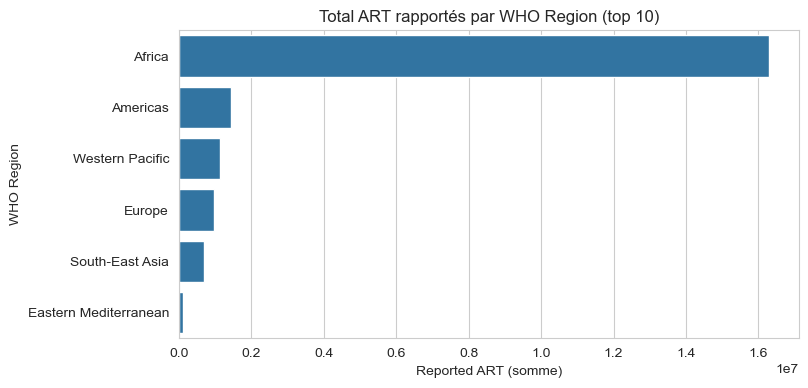

In [15]:
plt.figure(figsize=(8,4))
if col_region in df.columns:
    # top 10 régions/pays par ART_reported_num
    top = df.groupby(col_region)['ART_reported_num'].sum().sort_values(ascending=False).head(10)
    sns.barplot(x=top.values, y=top.index)
    plt.title('Total ART rapportés par WHO Region (top 10)')
    plt.xlabel('Reported ART (somme)')
    plt.show()



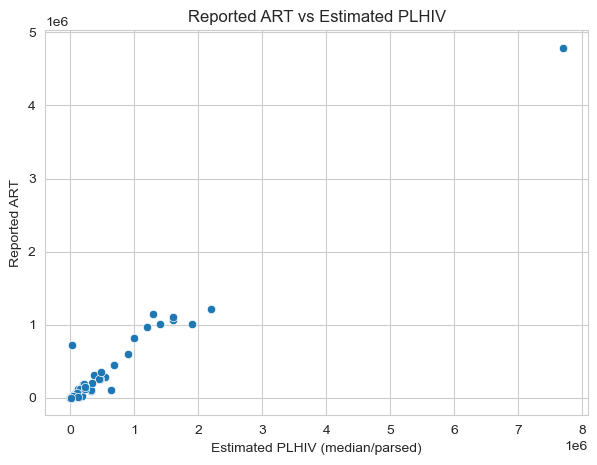

In [16]:
plt.figure(figsize=(7,5))
sns.scatterplot(data=df, x='Est_PLHIV', y='ART_reported_num')
plt.title('Reported ART vs Estimated PLHIV')
plt.xlabel('Estimated PLHIV (median/parsed)')
plt.ylabel('Reported ART')
plt.show()



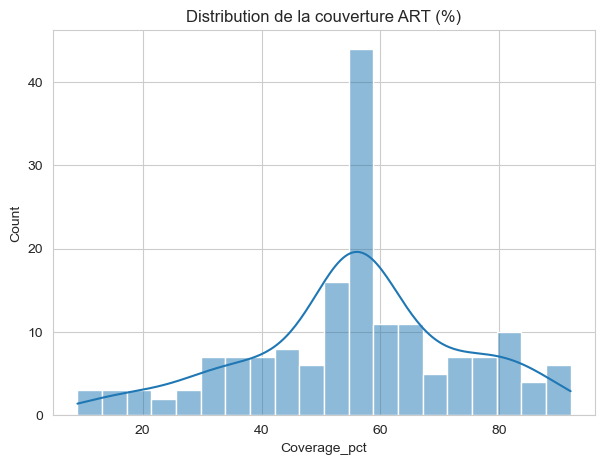

In [17]:
plt.figure(figsize=(7,5))
sns.histplot(df['Coverage_pct'], bins=20, kde=True)
plt.title('Distribution de la couverture ART (%)')
plt.show()

In [18]:
df['HighCoverage'] = (df['Coverage_pct'] >= 50).astype(int)
print("\nRépartition de la cible HighCoverage :")
display(df['HighCoverage'].value_counts(normalize=True))



Répartition de la cible HighCoverage :


HighCoverage
1    0.723529
0    0.276471
Name: proportion, dtype: float64

In [19]:
features_num = ['ART_reported_num','Est_PLHIV']
X_num = df[features_num].copy()

In [20]:
if col_region in df.columns:
    region_dummies = pd.get_dummies(df[col_region], prefix='WHO', drop_first=True)
    X = pd.concat([X_num, region_dummies], axis=1)
else:
    X = X_num.copy()

y = df['HighCoverage']


In [21]:

print("\nNaNs dans X :", X.isna().sum().sum())


NaNs dans X : 0


In [22]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [23]:
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)
y_pred_dt = dt_model.predict(X_test)

print("\n[DecisionTree] Accuracy :", accuracy_score(y_test, y_pred_dt))
print("[DecisionTree] Classification report:\n", classification_report(y_test, y_pred_dt))



[DecisionTree] Accuracy : 0.7058823529411765
[DecisionTree] Classification report:
               precision    recall  f1-score   support

           0       0.43      0.33      0.38         9
           1       0.78      0.84      0.81        25

    accuracy                           0.71        34
   macro avg       0.60      0.59      0.59        34
weighted avg       0.69      0.71      0.69        34



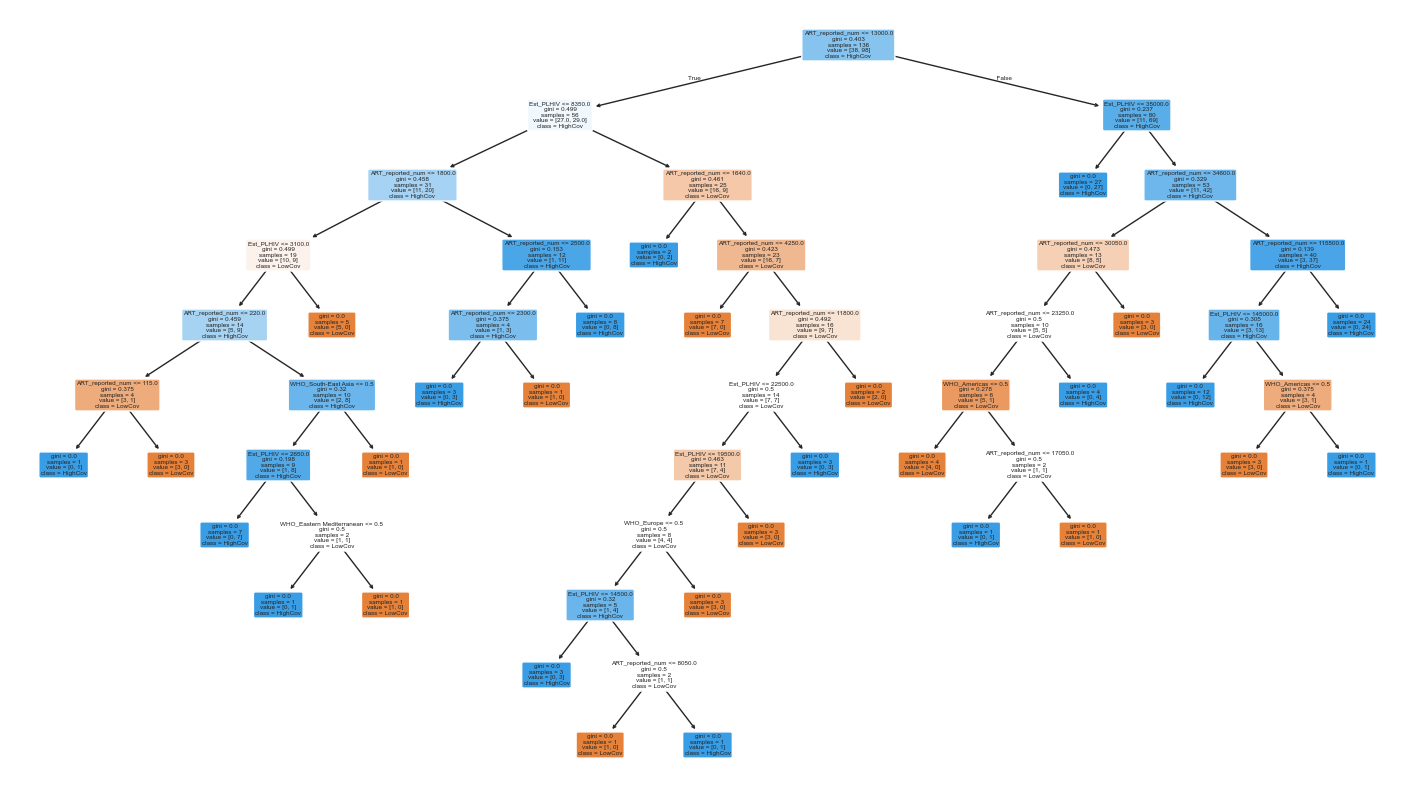

In [24]:
plt.figure(figsize=(18,10))
try:
    tree.plot_tree(dt_model, feature_names=X.columns, class_names=['LowCov','HighCov'], filled=True, rounded=True)
except Exception as e:
    tree.plot_tree(dt_model, feature_names=X.columns, filled=True)
plt.show()


In [32]:

X2 = df[features_num].values
y2 = df['HighCoverage'].values


scaler = StandardScaler()
X2_scaled = scaler.fit_transform(X2)


X2_train, X2_test, y2_train, y2_test = train_test_split(
    X2_scaled, y2, test_size=0.2, random_state=42, stratify=y2
)


svm_model = SVC(
    kernel='rbf',
    C=1,
    gamma='scale',
    class_weight='balanced'   
)


svm_model.fit(X2_train, y2_train)


y2_pred = svm_model.predict(X2_test)

print("\n[SVM] Accuracy :", accuracy_score(y2_test, y2_pred))
print("[SVM] Classification report:\n",
      classification_report(y2_test, y2_pred, zero_division=0))




[SVM] Accuracy : 0.3235294117647059
[SVM] Classification report:
               precision    recall  f1-score   support

           0       0.27      0.89      0.41         9
           1       0.75      0.12      0.21        25

    accuracy                           0.32        34
   macro avg       0.51      0.50      0.31        34
weighted avg       0.62      0.32      0.26        34



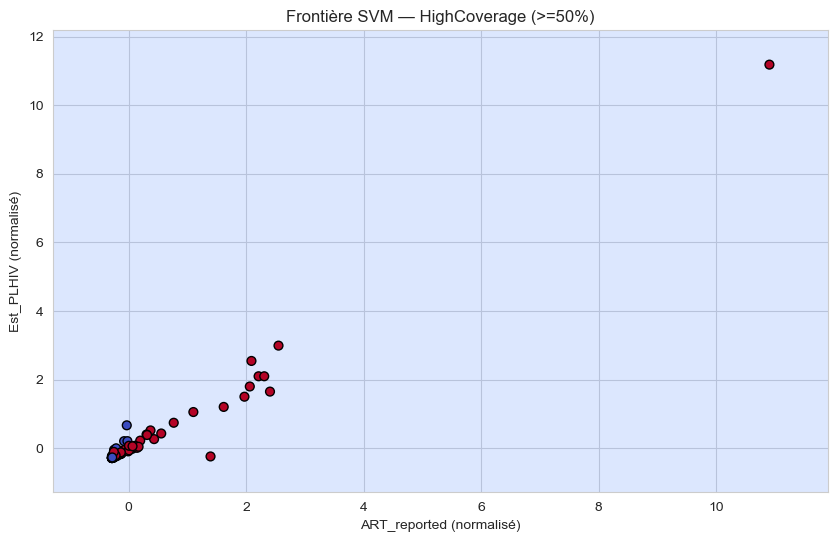

In [26]:
plt.figure(figsize=(10,6))
x_min, x_max = X2_scaled[:, 0].min() - 1, X2_scaled[:, 0].max() + 1
y_min, y_max = X2_scaled[:, 1].min() - 1, X2_scaled[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300), np.linspace(y_min, y_max, 300))

Z = svm_model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
plt.contourf(xx, yy, Z, alpha=0.3, cmap='coolwarm')

plt.scatter(X2_scaled[:, 0], X2_scaled[:, 1], c=y2, cmap='coolwarm', edgecolor='k', s=40)
plt.xlabel('ART_reported (normalisé)')
plt.ylabel('Est_PLHIV (normalisé)')
plt.title('Frontière SVM — HighCoverage (>=50%)')
plt.show()


In [27]:
df_clean = df.copy()

In [28]:
df_clean.to_csv("vih_clean.csv", index=False)
print("\nFichier nettoyé sauvegardé : vih_clean.csv")


Fichier nettoyé sauvegardé : vih_clean.csv
